# Vaja 2 - Filtriranje, detekcija robov, kotov, črt in krogov

Da uspešno opravite vajo, jo morate predstaviti asistentu na vajah. Pri nekaterih nalogah so vprašanja, ki zahtevajo skiciranje, ročno računanje in razmislek. Končno rešitev na takšna vprašanja vpišite v predvideni prostor, postopek reševanja pa razložite asistentu na vajah. Deli nalog, ki imajo pred navodilom navedene točke, niso obvezni. Brez njih lahko za celotno vajo dobite največ **75** točk (zgornja meja je **100** točk kar pomeni oceno 10). V nekaterih vajah je dodatnih nalog več in vam ni potrebno opraviti vseh.


In [1]:
# Run this cell to download the data used in this exercise
import zipfile, urllib.request, io, os
if not os.path.isfile("token"):
    print("Downloading exercise material")
    zipfile.ZipFile(io.BytesIO(urllib.request.urlopen("https://data.vicos.si/lukacu/rrz/vaja2.zip").read())).extractall()

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, Image
import threading
import time

class VideoViewer:
    """This class can be used to display video frame by frame in a Jupyter notebook."""

    def __init__(self, timeout = 2, clear = False):
        """
        :param timeout: Timeout in seconds after which the video display is stopped if no new frame is received.
        :param clear: If True, the video display is cleared after the last frame is received.
        """
        self._frame = None
        self._thread = None
        self._last_update = 0
        self._timeout = timeout
        self._clear = clear
        self._display_handle = display(None, display_id=True)
        self._mutex = threading.Lock()

    def _view(self):
        import time
        self._last_update = time.time()
        while True:
            with self._mutex:
                if self._frame is None:
                    if time.time() - self._last_update > self._timeout:
                        break
                    else:
                        continue
                try:
                    self._display_handle.update(Image(data=cv2.imencode('.jpeg', self._frame)[1].tobytes()))
                finally:
                    pass
                self._frame = None
                self._last_update = time.time()
            time.sleep(0.1)

        if self._clear:
            self._display_handle.update(None)
        self._thread = None

    def show(self, frame):
        """ Display a frame. If the previous frame has not been displayed yet, it is dropped. """
        with self._mutex:
            self._frame = frame
        if self._thread is None:
            self._thread = threading.Thread(target=self._view, args=())
            self._thread.start()

def video_demo():
    """ This function demonstrates the use of the VideoViewer class. """
    cap = cv2.VideoCapture(0)
    video = VideoViewer()
    try:
        while True:
            _, frame = cap.read()
            if frame is None:
                break
            video.show(frame)
            time.sleep(0.1)
    except KeyboardInterrupt:
        pass
    cap.release()
       

## Naloga 1: Konvolucija in filtriranje

Na predavanjih ste se spoznali z linearnim filtriranjem, katerega osrednji del je konvolucija. Najpres si oglejmo implementacijo konvolucije na 1D signalu. Konvolucija jedra $g(x)$ preko slike $I(x)$ je definirana z naslednjim izrazom

\begin{equation}
I_g(x) = g(x)*I(x) = \int_{-\inf}^{\inf}g(u)I(x-u)du
\end{equation}

oziroma v primeru diskretiziranih signalov

\begin{equation}
I_g(i) = g(i)*I(i) = \sum_{-\inf}^{\inf}g(j)I(i-j)dj
\end{equation}

Vizualizacijo konvolucije si lahko ogledate na spletni strani <a href="https://en.wikipedia.org/wiki/Convolution">Wikipedia</a>. Ker je ponavadi naše jedro končne velikosti, zgornja vsota teče samo od <i>levega roba</i> do njegovega <i>desnega roba</i>. Na primer, recimo, da je naše jedro $g$ velikosti $N + 1 + N$ elementov. V $i$-ti točki signala $I_g(i)$ se vrednost konvolucije v Pythonu izračuna kot:

``I_g[i] = np.sum(I[i-N:i+N+1] * g)``

To pomeni, da center jedra 'položimo' na signal $i$-ti točki in seštejemo produkt istoležnih elementov.

* Na roke izračunajte konvolucijo spodaj podanega signala in jedra $(k * f)$

  $f = [0, 1, 1, 1, 0, 0.7, 0.5, 0.2, 0, 0, 1, 0]$

  $k = [0.5, 1, 0.3]$

* Implementirajte funkcijo ``simple_convolution``, ki za vhod vzame 1D signal $I$ in simetrično jedro $g$ velikosti $2N + 1$, ter izračuna konvolucijo $I_g$. Zaradi enostavnosti lahko začnete konvolucijo računati na mestu $i = N$ in končate na $i = \mathrm{len}(I) - N - 1$. To pomeni, da za prvih $N$ elementov in zadnjih $N$ elementov signala $I$ konvolucije ne boste izračunali. Preverite implementacijo z uporabo spodaj definiranega signala in jedra. Na isti sliki izrišite signal, jedro in rezultat konvolucije.

In [3]:
signal = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
kernel = [0.0022181959, 0.0087731348, 0.027023158, 0.064825185, 0.12110939, 0.17621312, 0.19967563, 0.17621312, 0.12110939, 0.064825185, 0.027023158, 0.0087731348, 0.0022181959]

In [4]:
def simple_convolution(signal, kernel):
    signal = np.array(signal)
    kernel = np.array(kernel)
    
    N = int((len(kernel) - 1) / 2)
    Ig = np.zeros(len(signal))
    
    # TODO: Sprehodite se s for zanko z jedrom 'kernel' cez signal in izvedite konvolucijo.
    #        Rezultat konvolucije shranite v Ig
    raise NotImplementedError()

In [5]:
# TODO: Izrisite rezultat
raise NotImplementedError()

NotImplementedError: 

 * Ali prepoznate obliko jedra <i>kernel</i>? Kakšna je vsota vseh elementov jedra?

In [ ]:
# TODO: Odgovorite na vprasanje in izpisite vsoto vseh elementov jedra
raise NotImplementedError()

* Ponovno izračunajte konvolucijo in izrišite rezultat, vendar tokrat uporabite že vgrajeno Scipy funkcijo

    ``scipy.signal.convolve(signal, kernel, 'same')``

    Poglejte si v Scipy dokumentaciji kaj pomeni parameter ``same``. V čem se ta funkcije razlikuje od vaše implementacije ``simple_convolution``? Kaj je vzrok za razliko?

In [ ]:
# TODO: Izracunajte konvolucijo in izrisite rezultat
raise NotImplementedError()

* Sedaj si oglejmo zelo pogosto uporabljeno <i>Gaussovo jedro</i>, ki je definirano kot

    \begin{equation}
    g(x) = \frac{1}{\sqrt{2\pi}\sigma}\exp{(-\frac{x^2}{2\sigma^2})}
    \end{equation}

    Pomembna lastnost Gaussovega jedra je, da njegova vrednost postane zelo majhna za $\left|x\right| > 3\sigma$. Zato je tudi jedro ponavadi velikosti $2\cdot3\sigma+1$. Napišite funkcijo ``simple_gauss``, ki ji podate parameter ``sigma``, vrne pa Gaussovo jedro.

In [ ]:
def simple_gauss(sigma):
    # TODO
    raise NotImplementedError()

* Izrišite jedro s $\sigma=2$ in preverite, da je vsota njegovih elementov enaka $1$ ter, da je po obliki podoben zgoraj definiranem jedru ``kernel``. Na isto sliko izrišite še Gaussova jedra z vrednostjo $\sigma = 0.5, 1, 2, 3, 4$.

In [ ]:
# TODO: Izrisite razlicna Gaussova jedra
raise NotImplementedError()

* Na spodnji sliki sta prikazani dve jedri <i>(a)</i> in <i>(b)</i> ter signal <i>(c)</i>. Skicirajte (ni se potrebno osredotočati na računsko natančnost, pomembno je razumevanje) rezultat konvolucije signala s posameznim jedrom. Po želji lahko konvolucijo s podobnimi dvemi signali tudi implementirate, vendar je pombemno predvsem razumevanje rezultata.


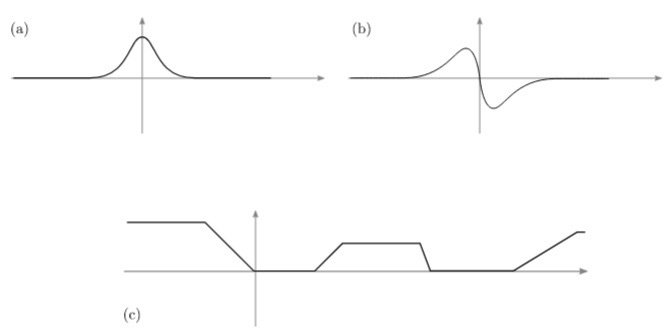

In [ ]:
# TODO
raise NotImplementedError()

* Glavna prednost konvolucije napram korelaciji je asociativnost operacije. To nam omogoča, da več jeder najprej konvuliramo med seboj, šele nato pa s sliko. Preverite to lastnost tako, da uporabite zgoraj definirani signal ``signal`` ter ga nato konvulirate z dvema jedroma, najprej z Gaussovim jedrom $k_1$ s parametrom $\sigma=2$, nato pa z jedrom $k_2 = [0.1, 0.6, 0.4]$. V drugem poskusu zamenjajte vrstni red jeder, nato pa preizkusite še najprej izračunati konvolucijo obeh jeder $k_1 * k_2$, rezultat pa konvulirajte s signalom. Izrišite vse tri rezultate in jih primerjajte.

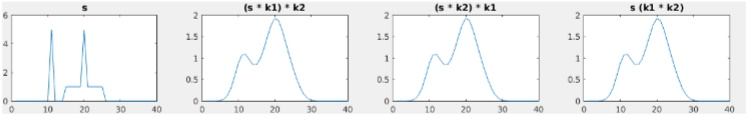

In [ ]:
# TODO
raise NotImplementedError()

* Kot ste to slišali že na predavanjih, je pomembna lastnost Gaussovega jedra separabilnost v večih dimenzijah. To pomeni, da dobimo enak rezultat, če enkrat filtriramo z 2D jedrom ali če filtriramo najprej po eni in nato po drugi dimenziji. Torej lahko (počasno) $n$D filtriranje prevedemo na sekvenco hitrih 1D filtriranj.

    Napišite funkcijo ``gauss_filter``, ki generira Gaussov filter in ga nato aplicira na 2D sliko. Za izvedbo funkcije v 2D prostoru uporabite OpenCV funkcijo ``cv2.filter2D``, oziroma funkcijo ``cv2.sepFilter2D``, ko uporabljate seperabilna jedra. Upoštevajte dejstvo, da je jedro separabilno, zato generirajte 1D jedro, z njim najprej filtrirajte sliko po eni dimenziji, nato pa po drugi dimenziji preprosto tako, da jedro transponirate pred konvolucijo. Preizkusite filter v spodnji kodi, ki naloži dve pokvarjeni varianti slike *lena.png* -- *lena_gauss.png* in *lena_sp.png*, kjer je bila prva varianta pokvarjena z Gaussovim šumom, druga pa s šumom sol-in-poper. Kateri šum Gaussov filter bolje odstrani?

In [ ]:
def gauss_filter(img, sigma):
    # TODO
    raise NotImplementedError()

In [ ]:
lena_gauss = cv2.imread('material/lena_gauss.png')
lena_sp = cv2.imread('material/lena_sp.png')

# TODO: Filtrirajte sliki z Gaussovim jedrom
raise NotImplementedError()

plt.figure()
plt.subplot(121)
plt.imshow(A_noise_gauss, cmap='gray')
plt.subplot(122)
plt.imshow(A_noise_sp, cmap='gray')

A_g_filtered = gauss_filter(A_noise_gauss, 1)
A_s_filtered = gauss_filter(A_noise_sp, 1)

plt.figure()
plt.subplot(121)
plt.imshow(A_g_filtered, cmap='gray')
plt.subplot(122)
plt.imshow(A_s_filtered, cmap='gray')

* **(5 točk)** Še en uporaben filter je filter ostrenja, ki je definiran kot

   $$
   k = \begin{bmatrix}
      0 & 0 & 0  \\
      0 & 2 & 0  \\
      0 & 0 & 0  \\
   \end{bmatrix}
   - \frac{1}{9}
   \begin{bmatrix}
      1 & 1 & 1 \\
      1 & 1 & 1 \\
      1 & 1 & 1 \\
   \end{bmatrix}
   $$

   Implementirajte filter ter ga preizkusite na sliki iz datoteke <i>museum.jpg</i>. Kaj opazite? Poskusite filter na sliki zaporedno aplicirati večkrat ter opazujte spremembe.

In [ ]:
def sharpen_filter(img):
    # TODO
    raise NotImplementedError()

In [ ]:
# TODO: Prikazite rezultat
raise NotImplementedError()

* Dopolnite implementacijo nelinearnega filter, ki ste ga obravnavali na predavanjih - <i>median filter</i>. Medtem, ko Gaussov filter izračuna lokalno uteženo povprečno vrednost v signalu, medianin filter lokalne vrednosti v signalu (t.j., vrednosti znotraj okna filtra) uredi po velikosti in vzame vrednost, ki je na sredini urejene množice (t.j., mediano).

In [ ]:
def simple_median(f, w):
    # f - input signal
    # w - širina filtra
    
    N = int(np.ceil((w - 1) / 2))
    f_filtered = np.zeros(len(f))
    # TODO
    raise NotImplementedError()

* Uporabite spodnjo funkcijo, ki generira 1D stopnico, jo pokvari s šumom sol-in-poper, in nato zažene vaš Gaussov in medianin filter. Nastavite parametre filtrov tako, da bo rezultat filtriranja najboljši. Kateri filter se obnese bolje?

In [ ]:
# signal
x = np.concatenate((np.zeros(14), np.ones(11), np.zeros(15)))
# pokvarjeni signal
xc = np.copy(x)
xc[11] = 5
xc[18] = 5

plt.figure()
plt.subplot(141)
plt.xlim([0, 40])
plt.ylim([0, 6])
plt.plot(x)
plt.subplot(142)
plt.xlim([0, 40])
plt.ylim([0, 6])
plt.plot(xc)
plt.subplot(143)
plt.xlim([0, 40])
plt.ylim([0, 6])
# TODO: plot simple gauss
# TODO: plot simple median

raise NotImplementedError()

* **(5 točk)** Implementirajte 2D verzijo medianinega filtra in jo preizkusite na sliki, ki je popačena z Gaussovim šumom ali šumom sol-in-poper. Primerjajte rezultate s filtriranjem z Gaussovim šumom za različne stopnje šuma, pa tudi za različne velikosti filtrov. Primerjajte (ocenite analitično) kolikša je računska kompleksnost Gaussovega filtra in kolikšna je kompleksnost medianinega filtra v $O(\cdot)$ notaciji, če v mediani uporabimo <i>quicksort</i> za sortiranje.

 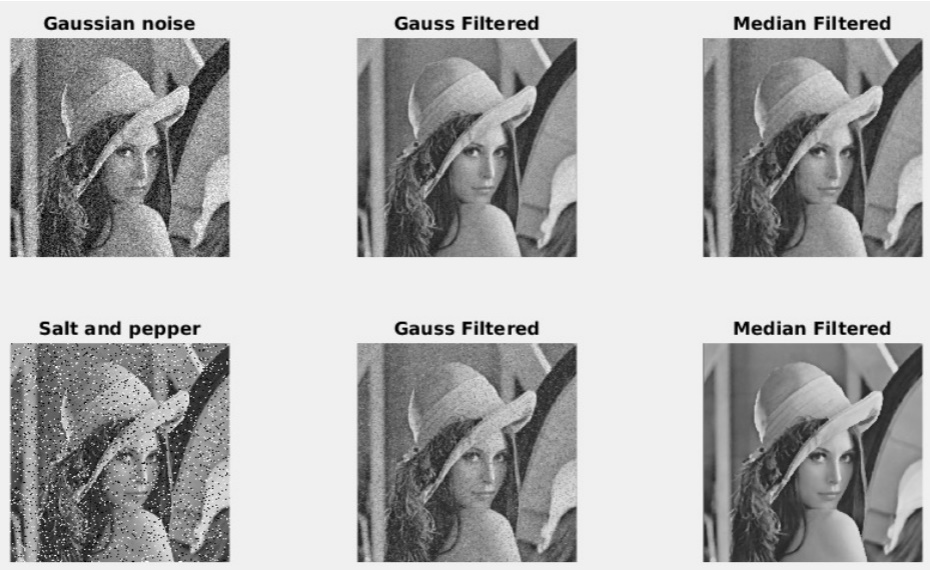

In [ ]:
# TODO
raise NotImplementedError()

* Zadnji segment v tej nalogi je posvečen odvajanju slik z uporabo konvolucije. Odvodi slike so pomembni kot indikator spremembe intenzitete, na njih pa temeljijo algoritmi za detekcijo črt in kotov. Numerično gre pri odvajanju za računanje razlike dveh zaporednih vrednosti signala, kar zapišemo tudi kot konvolucijo z jedrom $[-1, 1]$. Ker jedro s sodim številom elementov povzroči premik signala za pol elementa, se v praksi uporablja liha verzija filtra $[-1, 0, 1]$.

    Slabost neposrednega odvajanja slike v neki točki je v tem, da zaradi prisotnosti šuma lokalne spremembe niso jasne in so tudi ocene odvodov šumne. V praksi zato sliko najprej zgladimo z majhnim filtrom, $I_b(x, y) = G(x, y) * I(x, y)$ in šele nasto izračunamo odvod. Za glajenje pogosto uporabimo Gaussovo jedro, zaporedje odvajanja in konvolucije Z Gaussovim jedrom pa lahko zaradi lastnosti konvolucije združimo v konvolucijo z odvodom Gaussovega jedra.

* Implementirajte funkcijo za izračun odvoda 1D Guassovega jedra. Enačba odvoda Gaussovega jedra se glasi
    
    \begin{equation}
        \frac{d}{dx}g(x) = \frac{d}{dx}\frac{1}{\sqrt{2\pi}\sigma}\exp{\left(-\frac{x^2}{2\sigma^2}\right)} = -\frac{1}{\sqrt{2\pi}\sigma^3}x\exp{\left(-\frac{x^2}{2\sigma^2}\right)}
    \end{equation}
    
    Jedro implementirajte v funkciji ``simple_gaussdx(sigma)``. Kot smo normalizirali diskretizirano Gaussovo jedro, je tudi priporočljivo, da normaliziramo odvod jedra. Ker je odvod Gaussovega jedra liha funkcija, ga normaliziramo tako, da je vsota absolutnih vrednosti elementov vsake od polovic enaka 1. Torej moramo jedro deliti z $\frac{1}{2}\sum{\left|g_x(x)\right|}$.
    
    Slika je 2D signal, zato se na njej lahko izračuna dva parcialna odvoda, odvod po $x$ in odvod po $y$. Jedro odvoda po $y$ je transponirano jedro odvoda po $x$. Svojo implementacijo razširite še na 2D signal.

In [ ]:
def simple_gaussdx(sigma):
    # TODO
    raise NotImplementedError()

def simple_gaussdx2(sigma):
    # TODO
    raise NotImplementedError()

from matplotlib import pyplot as plt

y, x = simple_gaussdx(5)
y2, x2 = simple_gaussdx2(5)
plt.figure()
plt.plot(x, y)
plt.plot(x2, y2)
plt.legend("on")


 * Lastnosti filtra lahko analiziramo preko tako imenovanega impulznega odziva filtra $f(x, y)$, ki je definiran kot konvolucija. Dirac-ove $\delta(x, y)$ delte z jedrom $f(x, y)$: $f(x, y)*\delta(x, y)$. Zato najprej naredite sliko, ki ima vse vrednosti, razen centralnega elementa, enake nič

In [ ]:
I = np.zeros((25, 25), dtype=np.uint8)
I[12, 12] = 255

 * Sedaj generirajte spodaj podani 1D jedri $G$ in $D$

In [ ]:
sigma = 6.0
G = simple_gauss(sigma)
D = simple_gaussdx(sigma)

* Kaj se zgodi, če aplicirate naslednje operacije na sliko $I$? Ali je zaporedje ukazov pomembno?

    * Najprej konvolucija z G in potem konvolucija z G'.
    * Najprej konvolucija z G in potem konvolucija z D'.
    * Najprej konvolucija z D in potem konvolucija z G'.
    * Najprej konvolucija z G' in potem konvolucija z D.
    * Najprej konvolucija z D' in potem konvolucija z G.

    Izrišite si slike impulznih odzivov.

    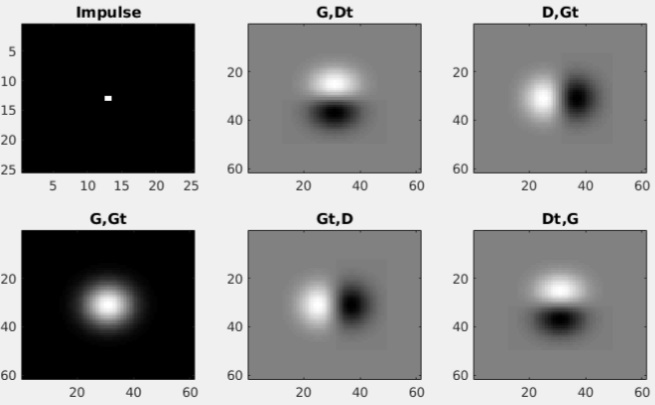


In [ ]:
# TODO
raise NotImplementedError()

## Naloga 2: Detekcija robov in kotov

Robove in kote iščemo tako, da analiziramo lokalne spremembe sivinskih nivojev v sliki, matematično to pomeni, da računamo <i>odvode</i> slike, kar ste si pogledali v prejšnji nalogi.

* **(5 točk)** Če želite bolje spoznati delovanje algoritma, implementirajte funkcijo ``gradient_magnitude``, ki za vhod vzame sivinsko sliko $I$, vrne pa matriko magnitud odvodov $I_\mathrm{mag}$ in matriko kotov odvodov $I_\mathrm{dir}$ vhodne slike. Magnitude izračunamo po formuli $m(x,y) = \sqrt{\left( I_x(x, y)^2 + I_y(x, y)^2\right)}$, kote pa po formuli $\Theta(x, y) = \mathrm{arctan}\left(\frac{I_y(x, y)}{I_x(x, y)}\right)$. Zaradi učinkovitosti je pomembno, da uporabite matrično obliko operacij in ne <i>for</i> zanke. Namig: Pri izračunu kotov se lahko ognete problemom deljenja z nič, če uporabite funkcijo ``np.arctan2``, ki sama poskrbi za take primere. Rezultate vseh treh funkcij preizkusite na sliki ``museum.jpg`` in izrišite rezultate.

    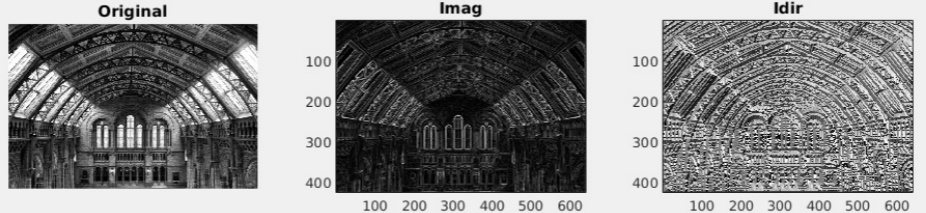


In [ ]:
def gradient_magnitude(I, sigma):
    # TODO
    raise NotImplementedError()

* **(5 točk)** Preprost detektor robov lahko dobimo že, če sliko magnitud gradientov $I_\mathrm{mag}$ upragujemo s pragom $\theta$. Napišite funkcijo ``edges_simple``, ki za sivinsko vhodno sliko vrne binarno sliko robov $I_e$, ki označuje magnitude večje od predpisane pragovne vrednosti. Implementirano funkcijo preizkusite na sliki ``museum.jpg`` in si izrišite rezultat za nekaj vrednosti parametra $\theta$.

In [ ]:
def edges_simple(I, theta):
    # TODO
    raise NotImplementedError()

* Na predavanjih ste spoznali Cannyjev detektor robov, ki je eden on najbolj razširjenih detektorjev robov v slikah. V OpenCV knjižnici je implementiran v sklopu funkcije ``cv2.Canny``. Preučite nabor njegovih vhodnih parametrov in preizkusite delovanje na slikah zajetih s pomočjo spletne kamere ali v video posnetku. Izberite si poljuben predmet in nastavite parametre tako, da se bo njegov obris najbolje videl.

In [ ]:
viewer = VideoViewer()

cap = cv2.VideoCapture(0)  # 0 = privzeta spletna kamera

# While zanka za posodabljanje pridobljene slike do prekinitve
try:
    while True:
        # Poskusajmo pridobiti trenutno sliko iz spletne kamere
        ret, frame = cap.read()
        
        # Ce to ni mogoce (kamera izkljucena, itd.), koncajmo z izvajanjem funkcije
        if ret == False:
            break

        # TODO: pridobite sliko robov
        raise NotImplementedError()
        
        # Prikazi sliko robov - edges
        viewer.show(edges)
        
except KeyboardInterrupt:
    pass

# Izklopi kamero in zapri okno
cap.release()

* Z odvodi lahko detektiramo tudi druge nizko-nivojske strukture v sliki, recimo kote. Na predavanjih ste obravnavali Harrisov algoritem, ki, podobno kot algoritmi za detekcijo črt, temelji na prvih odvodih slike. V OpenCV knjižnici je implementiran v sklopu funkcije ``cv2.cornerHarris``. Preučite nabor njegovih vhodnih parametro in preizkusite delovanje na slikah zajetih s pomočjo spletne kamere ali v video posnetku. Pri tem se zgledujte po zgornjem primeru. Poskusite nastaviti parametre tako, da boste detektirali čimveč kotov na npr. šahovnici, su-do-ku polju, itd.

In [ ]:
# TODO
raise NotImplementedError()

## Naloga 3: Detekcija črt in krogov

Ko imamo za sliko detektirane robove, lahko na podlagi njih detektiramo višje-nivojske strukture kot so črte/premice in krogi. Temu so namenjene različne izpeljanke <a href="https://en.wikipedia.org/wiki/Hough_transform">Hughovega algoritma</a>. Najprej boste na kratko obnovili bistvo Haughovega pristopa za iskanje premic v sliki. Za več informacij poglejte zapiske s predavanj, kot tudi spletne aplikacije (<a href="https://homepages.inf.ed.ac.uk/rbf/HIPR2/houghdemo.htm">Hough Transform</a>, <a href="https://www.markschulze.net/java/hough/">Circular Hough Transform</a>), ki demonstrirajo delovanje Houghovega transforma.

Zamislimo si neko točko $p_0 = (x_0, y_0)$ na sliki. Če vemo, da je enačba premice $y = mx+c$, katere vse premice potekajo skozi točko $p_0$? Odgovor je preprost: vse premice, katerih parametra $m$ in $c$ ustrezata enačbi $y_0 = mx_0 + c$. Če si fiksiramo vrednosti $(x_0, y_0)$, potem zadnja enačba opisuje zopet premico, vendar tokrat v prostoru $(m, c)$. Če si zdaj zamislimo novo točko $p_1 = (x_1, y_1)$, njej prav tako ustreza premica v prostoru $(m, c)$, in ta premica se seka s prejšnjo v neki točki $(m', c')$. Točka $(m', c')$ pa ravno ustreza parametrom premice v $(x, y)$ prostoru in povezuje točki $p_0$ in $p_1$.

* Na papirju rešite naslednji problem z uporabo Houghove transformacije: V 2D prostoru imamo podane štiri točke $(0, 0)$, $(1, 1)$, $(1, 0)$, $(2, 2)$. Določite enačbe premic, ki potekajo skozi vsaj dve točki. Poslikajte/skenirajte rešitev in jo dodajte v zvezek.

* Na papirju z uporabo Houghovega algoritma določite parametre premice, ki poteka čez točki $(10, 1)$ in $(11, 0)$.

* Če želimo poiskati vse premice v sliki z algoritmom, moramo naš postopek nekoliko preoblikovati, nimamo namreč na voljo neskončnega pomnilnika, ki bi ga potrebovali za izris premic, kot smo to naredili v zgornjih nalogah. Parametrični prostor $(m, c)$ najprej kvantiziramo v matriko <i>akumulatorjev</i>. Za vsak slikovni element, ki je kandidat za rob v vhodni sliki, <i>narišemo</i> pripadajočo premico v prostoru $(m, c)$ in povečamo vrednost akumulatorjev preko katerih ta premica poteka za $1$. Vsi slikovni elementi, ki ležijo na isti premici v vhodni sliki bodo generirali premice v prostoru $(m, c)$, ki se bodo sekale v isti točki in tako poudarile vrednost pripadajočega akumulatorja. To pomeni, da lokalni maximumi v $(m, c)$ prostoru določajo premice, na katerih leži veliko slikovnih elementov v $(x, y)$ prostoru.

    V praksi je zapis premice v odvistnosti od $m$ in $c$ neučinkovit, še posebej, ko gre za navpične črte, saj takrat postane $m$ neskončen. Temu problemu se preprosto ognemo tako, da premico parametriziramo s polarnimi koordinatami.

    \begin{equation}
    x\cos{\left(\theta\right)} + y\sin{\left(\theta\right)} = \rho
    \end{equation}

    Postopek iskanja parametrov z akumulatorji je nespremenjen, razlika je samo v tem, da točka v $(x, y)$ prostoru generira namesto premice sinusoido v prostoru $(\theta, \rho)$. Za točki $(1, 1)$ ter $(\frac{1}{2}, -1)$ sta ustrezni krivulji prikazani na spodnji sliki.

    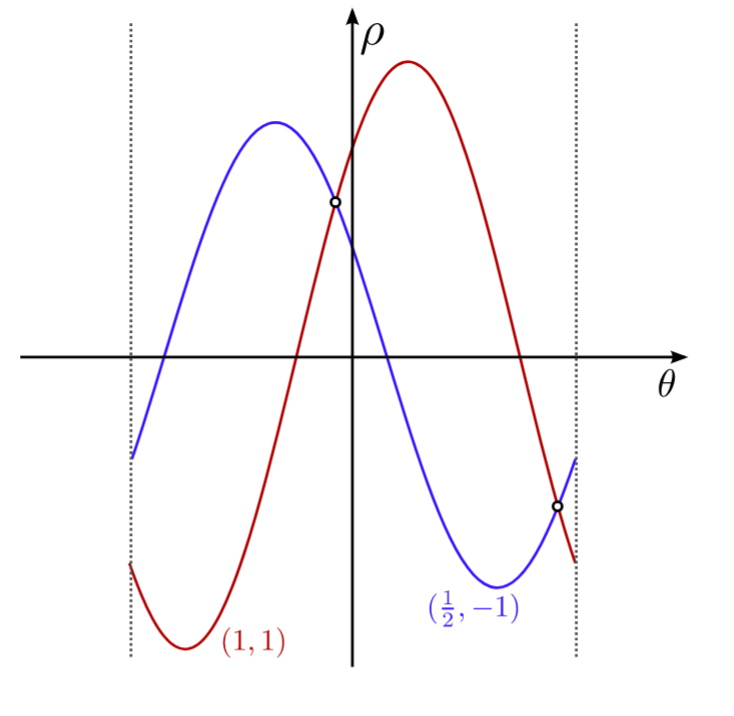

* Da bi bolje razumeli, kako se Houghov algiritem izvaja v praksi, ga boste delno implementirali. Pri tam vam bo v pomoč spodnja koda, ki za posamezno točko roba v akumulatorsko polje doda eno krivuljo.

In [ ]:
# Resolucija akumulatorskega polja:
bins_theta = 300
bins_rho = 300

max_rho = 100  # Navadno je to diagonala slike

val_theta = np.linspace(-90, 90, bins_theta) / 180 * np.pi # vrednosti theta
val_rho = np.linspace(-max_rho, max_rho, bins_rho)
A = np.zeros((bins_rho, bins_theta))

# Primer za tocko (50, 90)
x = 50
y = 90
rho = x * np.cos(val_theta) + y * np.sin(val_theta) # Izracunajmo rho za vse thete
bin_rho = np.round((rho + max_rho) / (2 * max_rho) * len(val_rho))

for i in range(bins_theta):
    if bin_rho[i] >= 0 and bin_rho[i] <= bins_rho - 1:
        A[int(bin_rho[i]), i] += 1
        
plt.figure()
plt.imshow(A)

* Razširite zgornjo kodo, da iz slike robov (le-to lahko pridobite z uporabo Cannyjevega detektorja robov), inkrementalno izračunajte vrednosti akumulatorske matrike tako, da za vsako točko, ki je rob, dorišete ustrezno krivuljo. Končni akumulator nato prikažite na zaslonu. Za testiranje uporabite sintetični sliki iz datotek ``oneline.png`` in ``rectangle.png``. Pri tem bodite pozorni na nastavitev vrednosti spremenljivke ``max_rho``, ki se spreminja glede na velikost slike.

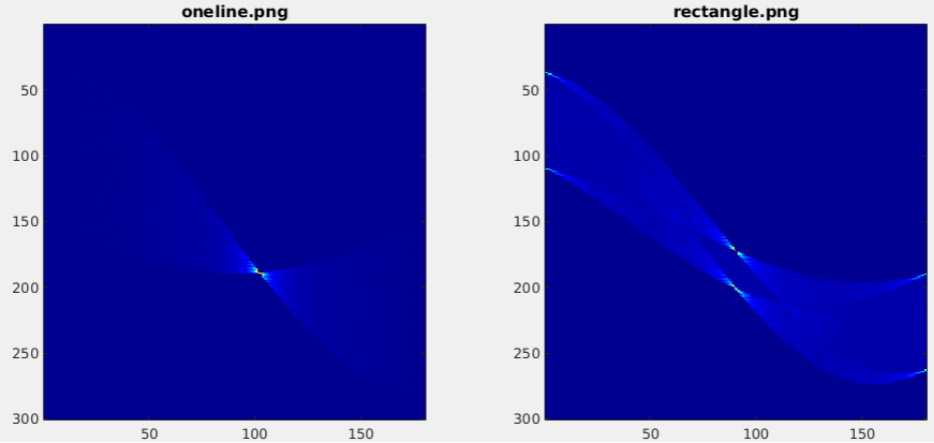


In [ ]:
# TODO
raise NotImplementedError()

* Kot je bilo rečeno, algoritma za detekcijo premic ne boste implementirali v celoti, zato uporabite raje v nadaljevanju že implementirano OpenCV funkcijo ``cv2.HoughLinesP``.

    Naložite sliki iz datotek ``skyscraper.jpg`` in ``pier.jpg``. Sliki spremenite v sivinski in na njej najprej detektirajte robove s pomočjo funkcije ``cv2.Canny``, nato pa detektirajte črte z uporabo funkcije ``cv2.HoughLinesP``. Prikažite rezultate ter preizkusite različne nabore parametrov algoritma detekcije robov ter detekcije črt, npr. spremenite parameter $\sigma$ v detekciji črt ali število celic akumulatorja, da dobite rezultate, ki so podobni ali boljši od rezultatov na spodnji sliki. Za izris črt uporabite funkcijo ``cv2.line`` znotraj <i>for</i> zanke.
    
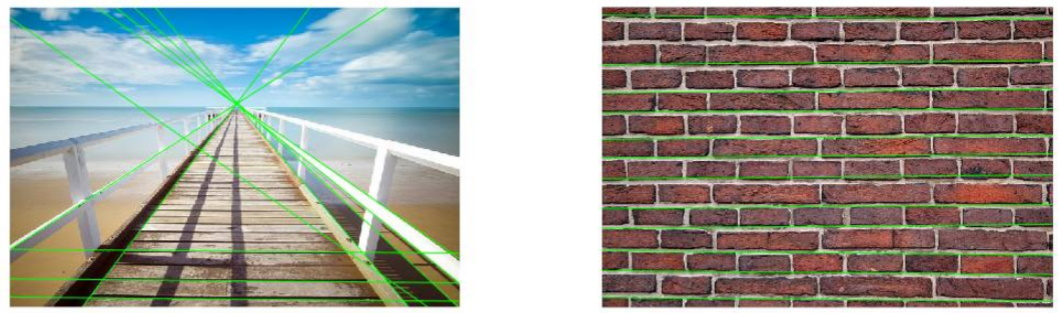


In [ ]:
# TODO
raise NotImplementedError()

* Ko dosežete zadovoljive rezultate preizkusite delovanje svojega algoritma še na slikah, pridobljenih iz spletne kamere ali video posnetka. Delovanje detekcije črt preizkusite s pomočjo npr. su-do-ku polja, črt v zvezku itd.

In [ ]:
# TODO:
# Za vsako sliko v toku:
#  * Pretvorite sliko v sivinsko
#  * Detektirajte robove na sliki
#  * Na sliki robov detektirajte črte, pri tem se zgledujte po naslednjem primeru:
#    lines - seznam tock crt, ki nam jih vrne funkcija cv2.HoughLinesP
#    if lines is not None:
#        for i in range(len(lines)):
#            for x1, y1, x2, y2 in lines[i]:
#                cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
raise NotImplementedError()

 * Sedaj si bomo pogledali še, kako se Houghova transformacija uporabi za detekcijo krogov. Postopek je podoben, kot v primeru detekcije črt, le da imamo v splošnem pri krožnicah tri parametre: dva za center ter enega za radij.

    Zamislimo si neko točko $p_0 = (x_0, y_0)$ na sliki. Če vemo, da je enačba krožnice $r^2 = (x-x_c)^2 + (y - y_c)^2$, katere vse krožnice potekajo skozi točko $p_0$? Vse krožnice, katerih parametri $x_c$, $y_c$ in $r$ ustrezajo enačbi $r^2 = (x_0 - x_c)^2 + (y_0 - y_c)^2$. Če si fiksiramo vrednosti $(x_0, y_0)$, potem zadnja enačba opisuje stožec v $3$D prostoru $(x_c, y_c, r)$. Ideja je prikazana na spodnji sliki.

    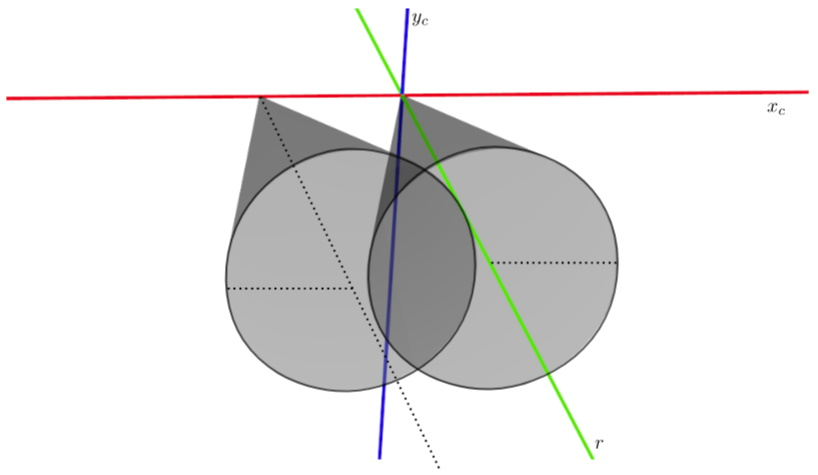

* Pogosto lahko obravnavamo problem iskanja krožnic, ko imamo radij že poznan. Kakšna je v tem primeru enačba, ki jo ena točka generira v parametričnem prostoru?

* Na papirju rešite naslednji problem z uporabo Houghove transformacije: V sliki iščemo kroge s fiksnim radijem $r=4$. Obravnavajte točki $A = (4, 8)$ in $B = (8, 4)$. Za vsako točko napišite enačbo v parametričnem prostoru in narišite pripadajočo krivuljo. Kaj lahko povemo o točkah $A$ in $B$?

In [ ]:
# TODO
raise NotImplementedError()

* Implementacija algoritma je podobna, kot pri detekciji premic, gre enostavno za drugačno enačbo. V nadaljevanju preizkusite OpenCV implementacijo ``cv2.HoughCircles`` s pomočjo katere detektirajte kroge na slikah ``eclipse.jpg`` in ``coins.jpg``. V prvem primeru eksperimentirajte z vrednostmi radija med $45$ in $50$ slikovnih elementov, v drugem pa preizkusite radije nekje med $85$ in $90$ slikovnih elementov. Za izris krogov uporabite funkcijo ``cv2.circle``.

    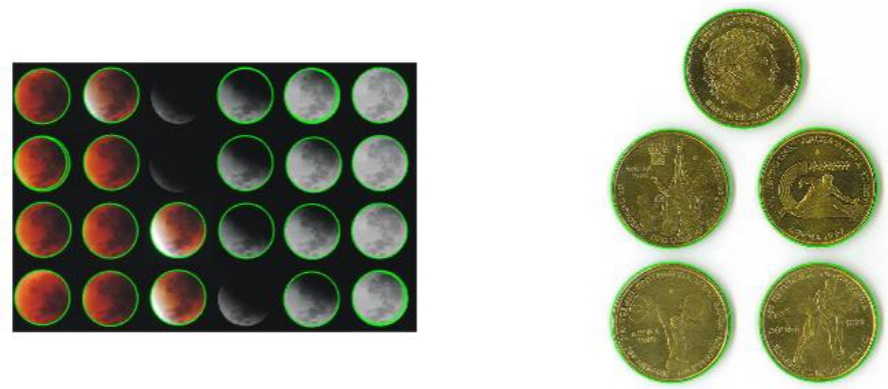

In [ ]:
# TODO
raise NotImplementedError()

* Ko dosežete zadovoljive rezultate preizkusite delovanje svojega algoritma še na živi sliki, t.j. sliki pridobljeni s pomočjo spletne kamere. Delovanje detekcije krogov preizkusite s pomočjo npr. kovancev na mizi.

In [ ]:
# TODO
raise NotImplementedError()